In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
sns.set_style("whitegrid")
sns.set_context("poster")
from itertools import product
from random import sample
from numpy.random import ranf
from collections import Counter

In [2]:
# Bill James Log 5

In [3]:
def log5(p,q):
    if p>1:
        p = p/float(100)
        q = q/float(100)
    return (p-p*q)/(p+q-2*p*q)

Wall time: 1.26 s


c:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


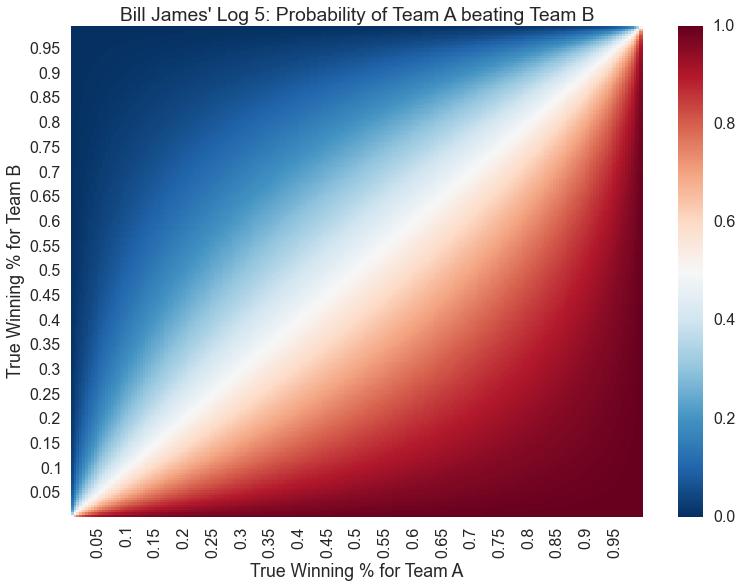

In [4]:
%%time

step = .005
min_ = step
max_ = 1

vals = np.arange(min_,max_,step)

heatmap = [[log5(v, v_) for v in vals] for v_ in reversed(vals)]

num = .05/step

test = ["" if i % num != num-1 else x for i, x in enumerate(vals)]

ax = sns.heatmap(np.array(heatmap), vmin=0, vmax=1, center=.5, xticklabels=test, yticklabels=list(reversed(test)))
ax.set_xlabel("True Winning % for Team A")
ax.set_ylabel("True Winning % for Team B")
ax.set_title("Bill James' Log 5: Probability of Team A beating Team B")
ax.set_xticklabels(test, rotation=90);

In [5]:
# Simply takes the Log5 of two teams to compute the winner.
#
# Signature: 
#
#   Inputs:
#     field:   This is a globally defined variable of the form {ranking : (name, scoring_params)}
#     p1:      an int representing the seed of a player in the field dictionary
#     p2:      same as p1
#     verbose: prints out matchup and winner
#
#   Outputs:
#     winner: The seed of the winner

def game(p1, p2, verbose=False):
    a, b = ranf(1), log5(field[p1][1], field[p2][1])
    if (a >= b):
        if verbose:
            print p1, "v", p2, "=>", p2
        return p2
    else:        
        if verbose:
            print p1, "v", p2, "=>", p1
        return p1

In [6]:
# Runs a single elimination tournament with no byes
#
# Signature: 
# 
#   Inputs:
#     draw:      This is a dictionary of the form {tournament seed : ranking}.  This allows for the minor randomization of
#                seeding in tennis.
#     scorefunc: The name of the function that will be used to compute who wins a matchup
#     verbose:   Print out matchup and winners
#     field:     This is required if the user wants to randomize the seeding in this function (but it is naive in randomization)
#                and is of the form {ranking : (name, scoring_params)}
#
#   Outputs:
#     winner: It outputs the winner of the tournament

def tournament(draw = None, scorefunc = game, verbose=False, field=None):
    if not draw or field:
        draw = {i+1 : v for i, v in enumerate(sample(field.keys(), len(field.keys())))}
    draw_ = draw.copy()
    playersleft = len(draw)
    rnd = 1
    while playersleft != 1:
        if verbose:
            print "Round", rnd
        n = len(draw_.values())
        draw_ = {v+1 : scorefunc(draw_[v+1], draw_[n-v], verbose) for v in range(n/2)}
        playersleft = len(draw_)
        rnd += 1
    return draw_.values().pop()

In [7]:
# Randomizes seeding following the ITF rules, which can be found on page 25: http://www.itftennis.com/media/195784/195784.pdf
#
# Signature: 
# 
#   Inputs:
#     field: This is a dictionary of the form {ranking : (name, scoring_params)} and is randomized in this function
#
#   Outputs:
#     seeding: This outputs a dictionary of the form {tournament seed : ranking}

def drawOpen(field):
    final_loc = {n+1 : "" for n in range(128)}
    randomization = sample(field.keys(), len(field.keys()))
    special_locations = {1 : [1], 
                     2 : [2],
                     3 : [3,4],
                     5 : [5,6,7,8],
                     9 : [9,10,11,12],
                     13 : [13,14,15,16],
                     17 : range(17,25),
                     25 : range(25,33)}
    regular_locations = [r for r in field.keys() if not any([r in s for s in special_locations.values()])]
    for r in randomization:
        if r in range(1,33):
            temp = [s for s in sorted(special_locations.keys())]
            for i, t in enumerate(temp):
                try:
                    if t<=r and temp[i+1]>r:
                        final_loc[special_locations[t].pop()] = r
                except:
                    final_loc[special_locations[temp[-1]].pop()] = r
        else:
            final_loc[regular_locations.pop()] = r
    return final_loc

In [8]:
%%time

field = {1 : ("Austin" , .7),
         2 : ("Brendan" , .4),
         3 : ("Carlos" , .8),
         4 : ("Daniel" , .3),
         5 : ("Edens" , .4),
         6 : ("Fraga" , .3),
         7 : ("Gilfix" , .55),
         8 : ("Harrison" , .75)}

a = [tournament(field=field) for _ in range(10000)]

for k, v in Counter(a).most_common():
    print field[k][0], v

Carlos 3900
Harrison 2779
Austin 1964
Gilfix 705
Brendan 237
Edens 218
Daniel 101
Fraga 96
Wall time: 482 ms


In [9]:
%%time
field = {n+1 : ('Player'+str(n+1), ranf(1)) for n in range(128)}

nsims = 100000
a = [tournament(drawOpen(field), game) for _ in range(nsims)]

for k, v in Counter(a).most_common():
    print k, field[k][1], v/float(nsims)

43 [ 0.99922214] 0.48978
37 [ 0.99912992] 0.4308
85 [ 0.99451972] 0.04266
98 [ 0.99257437] 0.0265
47 [ 0.98501617] 0.00893
32 [ 0.92661157] 0.00037
6 [ 0.91316558] 0.00018
41 [ 0.89028929] 0.00011
106 [ 0.8871249] 0.0001
99 [ 0.83727025] 8e-05
7 [ 0.86194245] 7e-05
77 [ 0.86746722] 7e-05
120 [ 0.84952695] 5e-05
27 [ 0.81751544] 4e-05
71 [ 0.82665876] 4e-05
12 [ 0.84384342] 3e-05
60 [ 0.80803775] 3e-05
78 [ 0.80677662] 3e-05
24 [ 0.80649677] 2e-05
40 [ 0.84227927] 2e-05
95 [ 0.77552843] 2e-05
126 [ 0.84793352] 2e-05
22 [ 0.70094941] 1e-05
33 [ 0.79373367] 1e-05
80 [ 0.73065622] 1e-05
88 [ 0.79319403] 1e-05
115 [ 0.71029772] 1e-05
Wall time: 6min 29s


In [10]:
def simPoint(s, r, rev=False, verbose=False):
    res = ranf(3)
    if verbose:
        print res
    if res[0]>=s[0]:
        if res[1]>=s[0]:
            return 0+rev
        else:
            if res[2]>=log5(s[2],r[4]):
                return 0+rev
            else:
                return 1-rev
    else:
        if res[2]>= log5(s[1],r[3]):
            return 0+rev
        else:
            return 1-rev

In [11]:
def simGame(players, server, verbose=False):
    s = players[1-server]
    r = players[server]
    s1, s2 = 0, 0
    winner = False
    while not winner:
        if simPoint(s, r, verbose):
            s1 += 1
        else:
            s2 += 1
        if abs(s1-s2)>=2 and max([s1,s2])>=4:
            winner = True
    if server:
        return (s1, s2)
    else:
        return (s2, s1)

In [12]:
def simTiebreak(players, server, verbose=False):
    if server:
        rev = False
    else:
        rev = True
    s1, s2 = 0, 0
    winner = False
    counter = 0
    while not winner:
        if counter % 2:
            rev=1-rev
        s=players[rev]
        r=players[1-rev]
        n = simPoint(s, r, rev, verbose=verbose)
        if verbose:
            print s,r,n
        if n:
            s1 += 1
        else:
            s2 += 1
        if abs(s1-s2)>=2 and max([s1,s2])>=7:
            winner = True
        counter += 1
    return (s1, s2)

In [13]:
players = [(.62,.79,.58,.32,.52),(.67,.76,.56,.34,.58)]

In [14]:
def simSet(players, server, tiebreak=True, verbose=False):
    s1, s2 = 0, 0
    for i in range(12):
        w = simGame(players,server,verbose)
        if w[0]>w[1]:
            s1 += 1
        else:
            s2 += 1
        server = 1-server
        if abs(s1-s2)>=2 and max([s1,s2])>=6:
            break
    if s1+s2 == 12:
        if tiebreak:
            t = simTiebreak(players, server, verbose)
            if t[0] > t[1]:
                s1 += 1
            else:
                s2 += 1
        else:
            winner = False
            while not winner:
                w = simGame(players,server,verbose)
                if w[0]>w[1]:
                    s1 += 1
                else:
                    s2 += 1
                server = 1-server
                if abs(s1-s2)>=2:
                    winner = True
                    break                
    return (s1, s2)

In [15]:
def simMatch(players, server, bestOf = 5, tiebreak=True, verbose=False):
    winCond = bestOf/2+1
    winner = False
    s1, s2 = 0, 0
    while not winner:
        res = simSet(players, server, tiebreak, verbose)
        if res[0]>res[1]:
            s1 += 1
        else:
            s2 += 1
        if verbose:
            print res
        if sum(res) % 2:
            server = 1-server
        if max(s1, s2) >= winCond:
            winner = True
    return (s1,s2)

In [16]:
%%time
lst = []
for i in range(200000):
    res = simMatch(players, 1, bestOf=5)
    lst.append(res[0]>res[1])

Wall time: 5min 36s


In [17]:
print sum(lst)/float(len(lst))
print sum(lst_)/float(len(lst_))

0.278725


NameError: name 'lst_' is not defined